# Identifying SRKW Orca Calls using CNN and SNN
## 02-Use CNN to identify SRKW calls [Excluding Round 1]

In [1]:
%matplotlib inline

Import libraries

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import glob
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

import tensorflow as tf
import keras.backend as K

from keras_preprocessing.image import ImageDataGenerator
from keras import models, layers, optimizers
from keras.models import  Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, GlobalAveragePooling2D, BatchNormalization, Concatenate
from keras.callbacks import EarlyStopping
from keras.layers.convolutional import Conv1D, Conv2D, MaxPooling2D
from keras.applications import DenseNet121

Define directories

In [3]:
parentdir="../"
codedir=parentdir+"code/"
datadir=parentdir+"data/"
train_dir=datadir+"TrainDataLatest_PodCastAllRounds_123567910/"
test_dir=datadir+"TestDataLatest_PodCastAllRounds_123/"
output=parentdir+"output/"
specdir=output+"spectrogram/"
specdir_train=specdir+"train/all/"
specdir_test=specdir+"test/all/"

In [4]:
directory_filenames_train_pos = glob.glob(specdir_train + '*_pos.png')
directory_filenames_train_neg = glob.glob(specdir_train + '*_neg.png')
directory_filenames_test_pos = glob.glob(specdir_test + '*_pos.png')
directory_filenames_test_neg = glob.glob(specdir_test + '*_neg.png')

In [5]:
f=os.path.join(train_dir,'annotations.tsv')
anno_table=pd.read_csv(f, sep='\t')
del(f)

f=os.path.join(test_dir,'test.tsv')
test_table=pd.read_csv(f, sep='\t')
del(f)

In [6]:
round1_wav=anno_table[anno_table['dataset']=='podcast_round1'].wav_filename.unique()

 Read in spectrograms

In [7]:
spectrogram_pos=[]
errors=[]
r1_pos=0
directory_filenames_train_pos_nr1=[]
ncol, nrow=224, 224
for i in range(len(directory_filenames_train_pos)):
    x=directory_filenames_train_pos[i]
    y='_'.join(x.split('/')[-1][:-8].split('_')[:-1])+'.wav'
    if y in round1_wav:
        r1_pos+=1
    else:
        directory_filenames_train_pos_nr1.append(x)
        img=cv2.imread(directory_filenames_train_pos[i])
        try:
            img=cv2.resize(img, (ncol, nrow))/255.0
        except:
            errors.append(i)
            pass 
        spectrogram_pos.append(img)
spectrogram_pos=np.asarray(spectrogram_pos, dtype=object)
del(i, img, x, y)

In [8]:
print(f'Excluded {r1_pos} postive spectrograms from Round 1. \
Remaining {len(spectrogram_pos)} positive spectrograms from other rounds.')

Excluded 3085 postive spectrograms from Round 1. Remaining 1751 positive spectrograms from other rounds.


Check the errors list. If the list is not empty, regenerate those samples.

In [9]:
for i in errors:
    print(i, directory_filenames_train_pos[i])

In [10]:
spectrogram_neg=[]
errors=[]
r1_neg=0
directory_filenames_train_neg_nr1=[]
ncol, nrow=224, 224
for i in range(len(directory_filenames_train_neg)):
    x=directory_filenames_train_neg[i]
    y='_'.join(x.split('/')[-1][:-8].split('_')[:-1])+'.wav'
    if y in round1_wav:
        r1_neg+=1
    else:
        directory_filenames_train_neg_nr1.append(x)
        img=cv2.imread(directory_filenames_train_neg[i])
        try:
            img=cv2.resize(img, (ncol, nrow))/255.0
        except:
            errors.append(i)
            pass 
        spectrogram_neg.append(img)
spectrogram_neg=np.asarray(spectrogram_neg, dtype=object)
del(i, img)

In [11]:
print(f'Excluded {r1_neg} negative spectrograms from Round 1. \
Remaining {len(spectrogram_neg)} negative spectrograms from other rounds.')

Excluded 9 negative spectrograms from Round 1. Remaining 568 negative spectrograms from other rounds.


In [12]:
for i in errors:
    print(i, directory_filenames_train_neg[i])

In [13]:
index_pos=list(range(len(directory_filenames_train_pos_nr1)))
index_neg=list(range(len(directory_filenames_train_neg_nr1)))
listpos=np.full((len(directory_filenames_train_pos_nr1),1), 1.0)
listneg=np.full((len(directory_filenames_train_neg_nr1),1), 0.0)

In [14]:
# Split up the training data into 80% train and 20% validation. 
# There is a set aside testing data that we will not use in the training.  
X_pos_train, X_pos_validation, y_pos_train, y_pos_validation, index_pos_train, index_pos_validation = train_test_split(spectrogram_pos, listpos, index_pos, test_size=0.2, random_state=76)
X_neg_train, X_neg_validation, y_neg_train, y_neg_validation, index_neg_train, index_neg_validation = train_test_split(spectrogram_neg, listneg, index_neg, test_size=0.2, random_state=76)

 Mix up the positive and negative smaple again in the train and validation cohorts

In [15]:
x_train=np.concatenate([X_pos_train, X_neg_train])
y_train=np.concatenate([y_pos_train, y_neg_train])
x_validation=np.concatenate([X_pos_validation, X_neg_validation])
y_validation=np.concatenate([y_pos_validation, y_neg_validation])
print(x_train.shape)
print(y_train.shape)
print(x_validation.shape)
print(y_validation.shape)

(1854, 224, 224, 3)
(1854, 1)
(465, 224, 224, 3)
(465, 1)


Creating a set testing data following similar steps as above

In [16]:
spect_test_pos=[]
errors=[]
ncol, nrow=224, 224
for i in range(len(directory_filenames_test_pos)):
    img=cv2.imread(directory_filenames_test_pos[i])
    try:
        img=cv2.resize(img, (ncol, nrow))/255.0
    except:
        errors.append(i)
        pass 
    spect_test_pos.append(img)
spect_test_pos=np.asarray(spect_test_pos, dtype=object)
del(i, img)

In [17]:
for i in errors:
    print(i, directory_filenames_test_pos[i])

In [18]:
spect_test_neg=[]
errors=[]
ncol, nrow=224, 224
for i in range(len(directory_filenames_test_neg)):
    img=cv2.imread(directory_filenames_test_neg[i])
    try:
        img=cv2.resize(img, (ncol, nrow))/255.0
    except:
        errors.append(i)
        pass 
    spect_test_neg.append(img)
spect_test_neg=np.asarray(spect_test_neg, dtype=object)
del(i, img)

In [19]:
for i in errors:
    print(i, directory_filenames_test_neg[i])

In [20]:
index_test_pos=list(range(len(directory_filenames_test_pos)))
index_test_neg=list(range(len(directory_filenames_test_neg)))
listtestpos=np.full((len(directory_filenames_test_pos),1), 1.0)
listtestneg=np.full((len(directory_filenames_test_neg),1), 0.0)

In [21]:
x_test=np.concatenate([spect_test_pos, spect_test_neg])
y_test=np.concatenate([listtestpos, listtestneg])
print(x_test.shape)
print(y_test.shape)

(809, 224, 224, 3)
(809, 1)


In [22]:
number_of_classes = y_train.shape[1]
print(number_of_classes)
DenseNet121_conv = DenseNet121(weights='imagenet', include_top=False, input_shape=(nrow, ncol, 3))

1


In [23]:
for layer in DenseNet121_conv.layers:
    layer.trainable = True

for layer in DenseNet121_conv.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7ff00da76f70> True
<keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7ff00c707d30> True
<keras.layers.convolutional.conv2d.Conv2D object at 0x7ff01692be20> True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7ff01692bf10> True
<keras.layers.core.activation.Activation object at 0x7ff01692b9a0> True
<keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7fea2287f820> True
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7fea2295c550> True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fea22962190> True
<keras.layers.core.activation.Activation object at 0x7fea229624c0> True
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fea2295ca60> True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fea2295cee0> True
<keras.layers.core.activation.Activation object at 0x7fea2295cdc0> True
<keras.layers.convolutional.

In [24]:
model = models.Sequential()
model.add(DenseNet121_conv)
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(number_of_classes, activation='sigmoid'))
optimizer = tf.keras.optimizers.Adam()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer = optimizer, metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 1024)              51381248  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 5

In [25]:
x_train=x_train.astype('float32')
y_train=y_train.astype('float32')
x_validation=x_validation.astype('float32')
y_validation=y_validation.astype('float32')
x_test=x_test.astype('float32')
y_test=y_test.astype('float32')

In [26]:
model_history = model.fit(x_train, y_train, batch_size=16, epochs=20, verbose=1, validation_data=(x_validation, y_validation))
y_train_pred_prob = model.predict(x_train)

Epoch 1/20
116/116 [==============================] - 1359s 11s/step - loss: 5.7790 - accuracy: 0.8657 - val_loss: 237823.7344 - val_accuracy: 0.7548
Epoch 2/20
116/116 [==============================] - 1374s 12s/step - loss: 6.4280 - accuracy: 0.7843 - val_loss: 503430.5625 - val_accuracy: 0.6387
Epoch 3/20
116/116 [==============================] - 1371s 12s/step - loss: 3.4151 - accuracy: 0.6931 - val_loss: 2.2768 - val_accuracy: 0.8043
Epoch 4/20
116/116 [==============================] - 1369s 12s/step - loss: 1.9893 - accuracy: 0.7265 - val_loss: 0.5610 - val_accuracy: 0.7548
Epoch 5/20
116/116 [==============================] - 1368s 12s/step - loss: 0.7152 - accuracy: 0.7389 - val_loss: 0.6424 - val_accuracy: 0.7548
Epoch 6/20
116/116 [==============================] - 1363s 12s/step - loss: 0.5686 - accuracy: 0.7449 - val_loss: 0.4942 - val_accuracy: 0.7548
Epoch 7/20
116/116 [==============================] - 1372s 12s/step - loss: 0.5364 - accuracy: 0.7519 - val_loss: 0.449

Text(0.5, 1.0, 'Predicted Probability of All Training Samples')

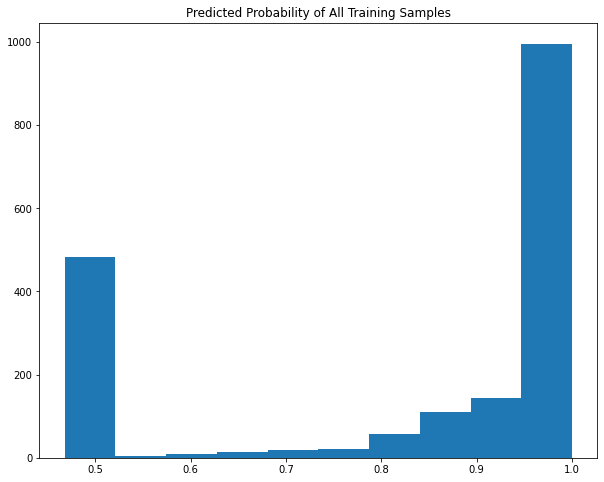

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (10, 8))
ax.hist(y_train_pred_prob[:,0])
ax.set_title('Predicted Probability of All Training Samples')

Prediction for labeled calls (Positive)

In [28]:
yhat_probs_Positive = model.predict(spectrogram_pos.astype('float32'))

55/55 [==============================] - 254s 5s/step


Text(0.5, 1.0, 'Predicted Probability of Positive Calls')

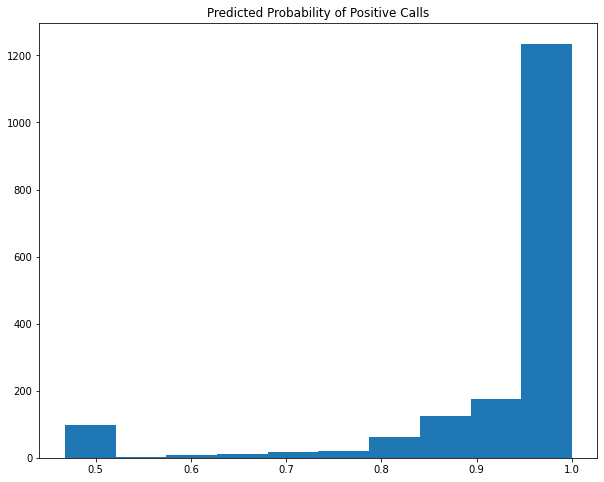

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (10, 8))
ax.hist(yhat_probs_Positive[:,0])
ax.set_title('Predicted Probability of Positive Calls')

In [30]:
tp_train=len([i for i in yhat_probs_Positive if i>=0.5])
fn_train=len([i for i in yhat_probs_Positive if i<0.5])
fnr_train=(fn_train)/(tp_train+fn_train)
print('False Negative Rate on the training data:', '{:.2%}'.format(fnr_train))

False Negative Rate on the training data: 5.37%


Prediction for no calls (Negative)

In [31]:
yhat_probs_Negative = model.predict(spectrogram_neg.astype('float32'))

18/18 [==============================] - 76s 4s/step


Text(0.5, 1.0, 'Predicted Probability of Negative Calls')

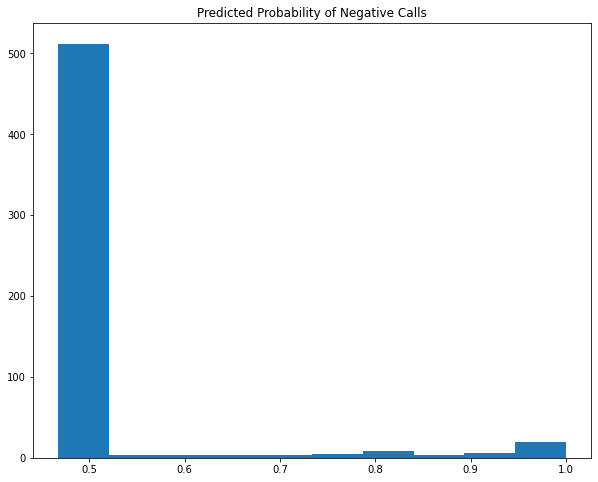

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (10, 8))
ax.hist(yhat_probs_Negative[:,0])
ax.set_title('Predicted Probability of Negative Calls')

In [33]:
tn_train=len([i for i in yhat_probs_Negative if i<0.5])
fp_train=len([i for i in yhat_probs_Negative if i>=0.5])
fpr_train=(fp_train)/(tn_train+fp_train)
print('False Positive Rate on the training data:', '{:.2%}'.format(fpr_train))

False Positive Rate on the training data: 10.21%


In [34]:
precision_train = tp_train / (tp_train + fp_train)
recall_train = tp_train / (tp_train + fn_train)
accuracy_train = (tp_train + tn_train) / (tp_train + fp_train + tn_train + fn_train)
print('Training Accuracy: %.4f' % accuracy_train)
print('Training Precision: %.4f' % precision_train)
print('Training Recall: %.4f' % recall_train)

Training Accuracy: 0.9345
Training Precision: 0.9662
Training Recall: 0.9463


Model Evalutaion

In [35]:
yhat_probs_test = model.predict(x_test.astype('float32'))

26/26 [==============================] - 108s 4s/step


Text(0.5, 1.0, 'Predicted Probability of Testing data')

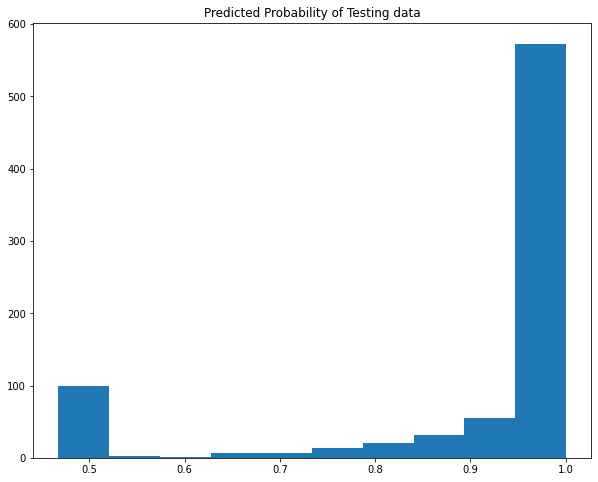

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (10, 8))
ax.hist(yhat_probs_test[:,0])
ax.set_title('Predicted Probability of Testing data')

In [37]:
yhat_probs_test_pos=yhat_probs_test[:len(directory_filenames_test_pos)]
yhat_probs_test_neg=yhat_probs_test[len(directory_filenames_test_pos):]
print(len(yhat_probs_test_pos), len(yhat_probs_test_neg))

731 78


Text(0.5, 1.0, 'Predicted Probability of Positive Testing data')

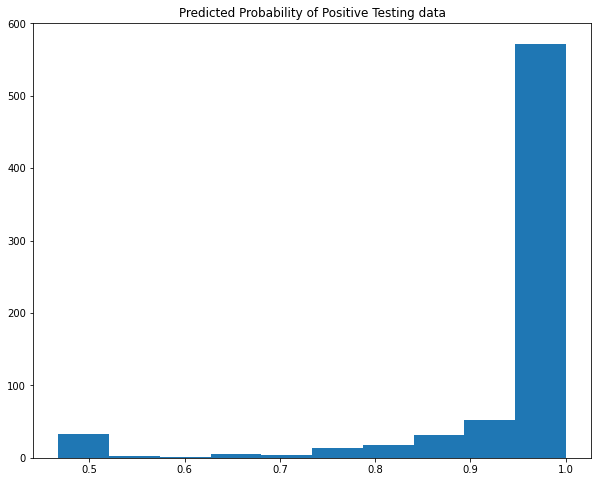

In [38]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (10, 8))
ax.hist(yhat_probs_test_pos[:,0])
ax.set_title('Predicted Probability of Positive Testing data')

Text(0.5, 1.0, 'Predicted Probability of Negative Testing data')

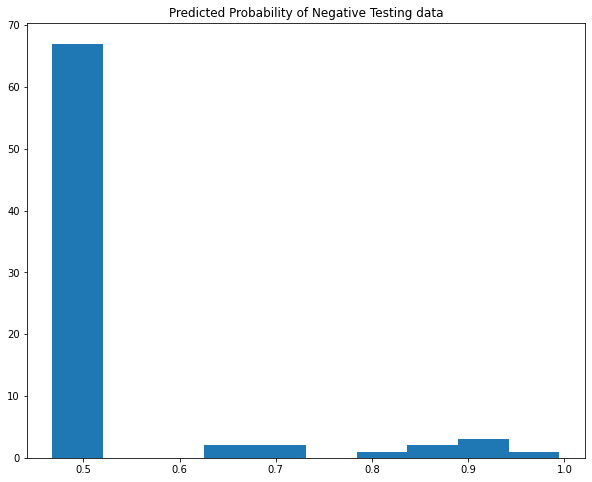

In [39]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (10, 8))
ax.hist(yhat_probs_test_neg[:,0])
ax.set_title('Predicted Probability of Negative Testing data')

In [40]:
tp=len([i for i in yhat_probs_test_pos if i>=0.5])
fn=len([i for i in yhat_probs_test_pos if i<0.5])
tn=len([i for i in yhat_probs_test_neg if i<0.5])
fp=len([i for i in yhat_probs_test_neg if i>=0.5])
print(tp, fn, tn, fp)
false_negative_rate = fn / (tp + fn)
false_positive_rate = fp / (tn + fp)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
accuracy = (tp + tn) / (tp + fp + tn + fn)
print('False Negative Rate:', '{:.2%}'.format(false_negative_rate))
print('False Positive Rate:', '{:.2%}'.format(false_positive_rate))

AUC = roc_auc_score(y_test, yhat_probs_test) 
print('AUC: %.4f' % AUC)
print('Accuracy: %.4f' % accuracy)
print('Precision: %.4f' % precision)
print('Recall: %.4f' % recall)

698 33 66 12
False Negative Rate: 4.51%
False Positive Rate: 15.38%
AUC: 0.9608
Accuracy: 0.9444
Precision: 0.9831
Recall: 0.9549


No handles with labels found to put in legend.


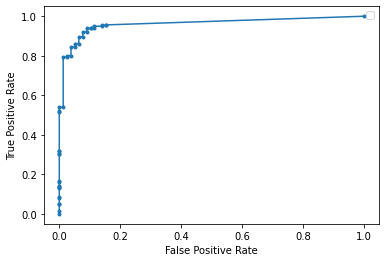

In [41]:
fpr, tpr, thresholds = roc_curve(y_test, yhat_probs_test)
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


No handles with labels found to put in legend.


Precesion Recall AUC: 0.9957


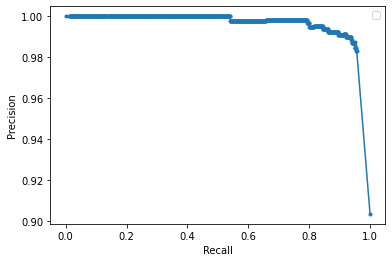

In [42]:
precision, recall, thresholds = precision_recall_curve(y_test, yhat_probs_test)
precision_recall_auc = auc(recall, precision)
print('Precesion Recall AUC: %.4f' % precision_recall_auc)

plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [43]:
output_positive_test = pd.DataFrame()
output_positive_test['path']=directory_filenames_test_pos
output_positive_test['pred']=yhat_probs_test_pos

Take a look at some false negative and false positive plots

False Negative

streaming-orcasound-net_2019_11_14_13_18_00_36_pos.png


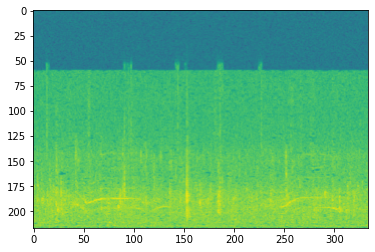

streaming-orcasound-net_2019_11_14_13_24_00_39_pos.png


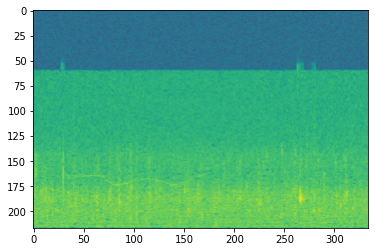

streaming-orcasound-net_2019_11_14_13_02_00_53_pos.png


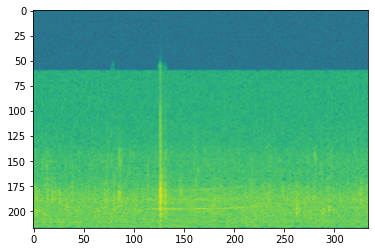

In [44]:
fnsample=output_positive_test.sort_values(by='pred', ascending=True).head(3)
for f in fnsample.path:
    print(f.split('/')[-1])
    img = mpimg.imread(f)
    imgplot = plt.imshow(img)
    plt.show()
del(f, img, imgplot)

Store false negative data to a csv file for later use.

In [45]:
fn_all=output_positive_test[output_positive_test.pred<0.5]
fn_all['wav_filename']=fn_all.path.apply(lambda x: '_'.join(x.split('/')[-1][:-8].split('_')[:-1])+'.wav')
fn_all['start_time_s']=fn_all.path.apply(lambda x: x.split('/')[-1][:-8].split('_')[-1])
tmptab=test_table
tmptab['start_time_s']=tmptab.start_time_s.apply(lambda x: str(int(x)))
fn_all=pd.merge(fn_all, tmptab, how='inner', on=['wav_filename', 'start_time_s'])
fn_all.to_csv(output+'false_neg.csv', index=False)
del(tmptab)

<ipython-input-45-ac383f1d1e7e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fn_all['wav_filename']=fn_all.path.apply(lambda x: '_'.join(x.split('/')[-1][:-8].split('_')[:-1])+'.wav')
<ipython-input-45-ac383f1d1e7e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fn_all['start_time_s']=fn_all.path.apply(lambda x: x.split('/')[-1][:-8].split('_')[-1])


In [46]:
output_negative_test = pd.DataFrame()
output_negative_test['path']=directory_filenames_test_neg
output_negative_test['pred']=yhat_probs_test_neg
output_negative_test_fp=output_negative_test[output_negative_test.pred>=0.5]

OS_9_27_2017_11_32_00__0002_0_neg.png


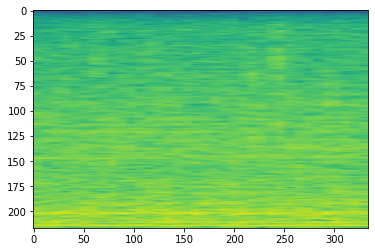

OS_9_27_2017_11_00_00__0004_0_neg.png


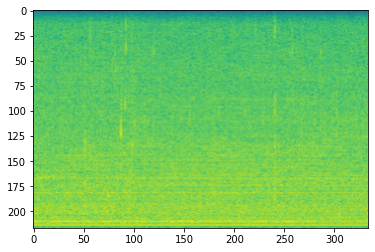

streaming-orcasound-net_2019_11_14_12_59_00_0_neg.png


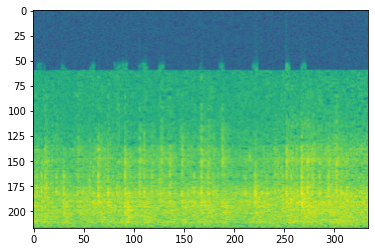

OS_9_27_2017_11_42_00__0000_0_neg.png


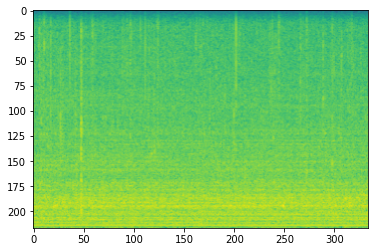

In [47]:
fpsample=output_negative_test.sort_values(by='pred', ascending=False).head(4)
for f in fpsample.path:
    print(f.split('/')[-1])
    img = mpimg.imread(f)
    imgplot = plt.imshow(img)
    plt.show()
del(f, img, imgplot)

Store false positive predictions to a csv file for later use.

In [48]:
fp_all=output_negative_test[output_negative_test.pred>=0.5]
fp_all['wav_filename']=fp_all.path.apply(lambda x: '_'.join(x.split('/')[-1][:-8].split('_')[:-1])+'.wav')
fp_all['start_time_s']=fp_all.path.apply(lambda x: x.split('/')[-1][:-8].split('_')[-1])
tmptab=test_table
tmptab['start_time_s']=tmptab.start_time_s.apply(lambda x: str(int(x)))
fp_all=pd.merge(fp_all, tmptab, how='inner', on=['wav_filename', 'start_time_s'])
fp_all.to_csv(output+'false_pos.csv', index=False)
del(tmptab)

<ipython-input-48-ac8b3cde89e7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fp_all['wav_filename']=fp_all.path.apply(lambda x: '_'.join(x.split('/')[-1][:-8].split('_')[:-1])+'.wav')
<ipython-input-48-ac8b3cde89e7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fp_all['start_time_s']=fp_all.path.apply(lambda x: x.split('/')[-1][:-8].split('_')[-1])
